In [88]:
!pip install pyspark

In [3]:
import pyspark
import pandas as pd
from pyspark.sql.types import *

In [4]:
import numpy as np
from pyspark.sql import SparkSession


In [13]:
import sys
import math
import matplotlib.pyplot as plt

In [6]:
spark=SparkSession.builder.appName('firstapp').getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/03/19 14:53:43 WARN Utils: Your hostname, Florian resolves to a loopback address: 127.0.1.1; using 172.28.140.145 instead (on interface eth0)
24/03/19 14:53:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/19 14:53:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
#load the dataset and add an index for each rows
data = spark.read.csv('./test.csv', header=True, inferSchema=True)
data = data.drop('Name')
df = data.toPandas()
df_index = pd.DataFrame({'index': range(0, len(df))})
result_df = pd.concat([df, df_index], axis=1)
data = spark.createDataFrame(result_df)
# asf = spark.createDataFrame(ee)
# asf.show()

In [8]:
#Select randomly five initials centroids
centers = data.toPandas().sample(n=5)
for i, ce in centers.iterrows():
    print(ce['Age'])
print(centers)
data.toPandas()[data.toPandas()['index'] == 8].iloc[0]
# npCenters = spark.createDataFrame(interDf)
# centers = npCenters

325
525
450
625
500
    Age    X   Y    Z  index
12  325  180  26   75     12
20  525  300  42  123     20
17  450  255  36  105     17
24  625  360  50  147     24
19  500  285  40  117     19


Age      225
X        120
Y         18
Z         51
index      8
Name: 8, dtype: int64

In [10]:
#Map operation
cols = [item for item in data.columns if(item != 'index')]
def euclideanDistance(x, y):
    dist = 0
    for dim in cols:
        dist = dist + (float(x[dim]) - float(y[dim]))**2
    dist = math.sqrt(dist)
    return dist
def map(x, cent):
    minDist = sys.float_info.max
    index = -1
    for i, center in cent.iterrows():
        distCenter = euclideanDistance(x, center)
        if(minDist > distCenter):
             minDist = distCenter
             index = int(center['index'])
        y = x.asDict()
        # del y['index']
        y['num'] = 1
        toSave = Row(**y)         
    return (index, toSave)
# rdd = data.rdd.map(lambda x: map(x)).groupByKey()
# e = rdd.toDF()
# for f in e.collect():
#     print(f)


In [11]:
def reduce(a, b):
    c = {}
    for column in cols:
        c[column] = float(a[column]) + float(b[column])
    c['num'] = float(a['num']) + float(b['num'])
    toSave = Row(**c)
    return toSave
def computeMean(y):
    g = y[1].asDict()
    for col in cols:
        g[col] = g[col]/g['num']
    g['index'] = int(y[0])
    return Row(**g)

In [12]:
centers = data.toPandas().sample(n=5)
valueObjFunc = []
for i in range(0, 10):
    mapResult = data.rdd.map(lambda x: map(x, centers))
    # for value in mapResult.collect():
    #     print(value)
    reduceResult = mapResult.reduceByKey(lambda a,b: reduce(a, b)).map(lambda q: computeMean(q))
    e = reduceResult.toDF()
    # for f in e.collect():
    #     print(f)
    error = mapResult.map(lambda x: (1, euclideanDistance(x[1], centers[centers['index'] == int(x[0])].iloc[0]))).reduceByKey(lambda a,b: a+b)
    for p in error.collect():
        print(p)
        valueObjFunc.append(p[1])
    centers = e.toPandas()
    # print()
    # print()
print(valueObjFunc)

(1, 1757.7051188226974)
(1, 1266.0192190377643)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
(1, 1250.6057511160782)
[1757.7051188226974, 1266.0192190377643, 1250.6057511160782, 1250.6057511160782, 1250.6057511160782, 1250.6057511160782, 1250.6057511160782, 1250.6057511160782, 1250.6057511160782, 1250.6057511160782]


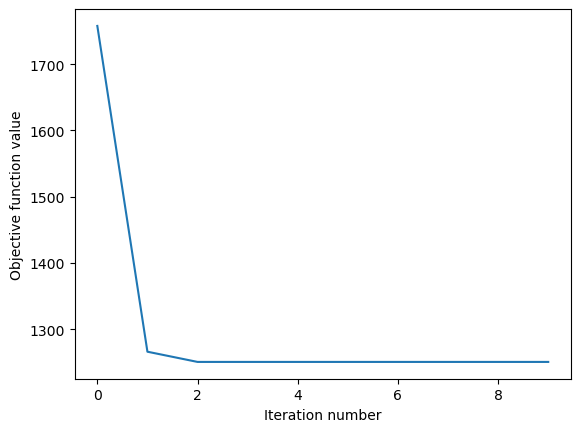

In [17]:
# for a in data.rdd.map(lambda x: map(x, centers)).collect():
#     print(a)
plt.plot(valueObjFunc)
plt.xlabel("Iteration number")
plt.ylabel("Objective function value")
plt.show()